# Sentiment analysis with Finnish AFINN models
#### - Binary labels (-1, ) as negative and positive
#### - For original HS dataset of 'raw' and 'corrected' samples
#### - Preprocessing and AFINN based classification

### This script was published as a part of reserch work
This script was created and published by Merja Kreivi-Kauppinen.

This script is part of research work carried at University of Oulu in 2020-2023.

Topic of research work and thesis:
'Signs of Paradigm Shift in Hate Speech Detection Methodology: Hate Speech Detection of Dialectal, Granular and Urban Finnish'


### Method of sentiment analysis

Social media trinary sentiment classification with afinn SA was carried on lemmatized samples, where words, emoticons and emojis were used to get sentiment scoring for text samples. 

Emoticons and emojis were taken into account in sentiment scoring.

Scoring was carried for 'raw' text samples and manually 'corrected' text samples.

Scoring with afinn was carried in three steps: (1) only for emoticons, (2) only for words, and (3) only for emojis.

 - (1) Text samples were tokenized with NLTK 'WhitespaceTokenizer' before emoticon scoring.

 - (2) Text samples were lemmatized with experimental Finnish Voikko method designed for Spacy (Spacy version 3.5.0) using large Finnish language model 'fi_core_news_lg' the source of tokens. Text samples were further tokenized with NLTK casual tokenization method, and set to lower capitals before feeding to afinn scoring process.

 - (3) Emojis of text samples were changed to english word forms before emoji scoring.

All three sentiment scores of text sample were fetched together, and after removal of zero values, the final scoring result of a sample was achieved by calculating the mean of scores.

The NaN results were set to zero, and the samples above zero was given label one (1) (indicating positive label) and the samples above zero was given label minus one (-1) (indicating negative label).

Results were analyzed with methods of scikit-learn library by calculating confusion matrix, and accuracy, F1, precision and recall scores for trinary classifier.

### Original afinn available in GitHub
Original version of Afinn method available at GitHub: https://github.com/fnielsen/afinn

Reference: Finn Årup Nielsen, "A new ANEW: evaluation of a word list for sentiment analysis in microblogs", Proceedings of the ESWC2011 Workshop on 'Making Sense of Microposts': Big things come in small packages. Volume 718 in CEUR Workshop Proceedings: 93-98. 2011 May. Matthew Rowe, Milan Stankovic, Aba-Sah Dadzie, Mariann Hardey (editors)

### Finnish AFINN lexicon for binary sentiment classification of Finnish (social media) text samples

Documentation of FINNfin library available as README.

Finnish AFINN for trinary classification of Finnish social media text uses lexicon which includes basic, pended, subword and lemma forms of words and their trinary labels.

All lexicons (words, emoticons, emojis) were provided on lexicographically descending order to enable more precise text, emoticon, symbol and emoji matching.

 - On emotion lexicon 'fin_afinn_trinary_MerjasList_2023.txt' each word is labeled with one sentiment label (-1, 1)
 
 - On emoticon lexicon 'afinn_emoticon_binary_MerjasList_2023.txt' each emoticon is labeled with one sentiment label (-1, 1)
 
 - On emoji lexicon 'afinn_emoji_binary_MerjasList_2023.txt' each emoticon is labeled with one sentiment label (-1, 1)


### The original AFINN method was sligthly modified before application to binary classification

New script available at file AFINN_scores.py

Changes in original script.
The Original AFinn class was replaced with

    - AFinnEmoticons class,
    
    - AFinnWords class, and
    
    - AfinnEmojis class

The AFinnWords class was used with 'word_boundary=True' flag to enable more precise text matching.

The AFinnWords class includes small changes in script.

New flags were added to AFinnEmoticons and AFinnEmojos classes.
The AFinnEmoticons and AFinnEmojis classes can be used with 
'emoticons_only=True' or 'emoticons_only=True' flag 
to enable text sample matching with emoticons or emojis only.

     - AFinnEmoticons class has 'emoticons_only' flag
     
     - AFinnEmojis class has 'emojis only' flag


## Import and check  jupyter python installations, packages, and libraries

In [1]:
# import python packages and libraries

import sys, re, os
import numpy as np
import pandas as pd
import string, math 
import time, datetime, random
print(f"\nPython Version: {sys.version} \n")

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams

# set seaborn figures
%matplotlib inline
rcParams['figure.figsize'] = 8, 4
sns.set(style='darkgrid', palette='muted', font_scale=1.0)


Python Version: 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)] 

The scikit-learn version is 1.1.2.


## Import NLP packages and AFINN for Finnish

In [2]:
import nltk
from nltk.tokenize import casual_tokenize, word_tokenize, sent_tokenize, WhitespaceTokenizer

# import Afinn form AFINNfin for Finnish 
import AFINNfin
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

import emoji
from emoji import *
import functools
import operator

## Import Experimental Spacy and Voikko

In [3]:
# Import and check Spacy
import spacy
print(f"Spacy Version: {spacy.__version__}")

# Load large Finnish model for spacy
FinSpacyLarge = spacy.load("fi_core_news_lg")

Spacy Version: 3.5.0


In [4]:
# Test large Finnish model

# Load large Finnish model
FinSpacyLarge = spacy.load("fi_core_news_lg")

# Test the model
doc = FinSpacyLarge('Terveyden ja hyvinvoinnin laitos (THL) johtaa hanketta. Ilmassa on kevättä. Rännit tippuvat ja katuojat juoksevat.')
for t in doc:
    print(f'{t.lemma_}\t{t.pos_}')

terveys	NOUN
ja	CCONJ
hyvinvointi	NOUN
laitos	NOUN
(	PUNCT
THL	NOUN
)	PUNCT
johtaa	VERB
hanke	NOUN
.	PUNCT
Ilmassa	NOUN
olla	AUX
kevät	NOUN
.	PUNCT
Rännit	NOUN
tippua	VERB
ja	CCONJ
katuoja	NOUN
juoksevat	VERB
.	PUNCT


In [5]:
from libvoikko import Voikko
print("\nCurrent working directory " , os.getcwd())


Current working directory  C:\Users\merja\Desktop\HS_research_project\AFINN_sentiment_analysis


In [6]:
# set up Voikko search path for Voikko help
Voikko.setLibrarySearchPath("c:/Voikko")
help(Voikko)

Help on class Voikko in module libvoikko:

class Voikko(builtins.object)
 |  Voikko(language, path=None)
 |  
 |  Represents an instance of Voikko. The instance has state, such as
 |  settings related to spell checking and hyphenation, and methods for performing
 |  various natural language analysis operations. One instance should not be
 |  used simultaneously from multiple threads.
 |  
 |  Methods defined here:
 |  
 |  __del__(self)
 |  
 |  __init__(self, language, path=None)
 |      Creates a new Voikko instance with the following optional parameters:
 |      language  BCP 47 language tag to be used.
 |      path      Extra path that will be checked first when looking for linguistic
 |                resources.
 |  
 |  analyze(self, word)
 |      Analyze the morphology of given word and return the list of
 |      analysis results. The results are represented as maps having property
 |      names as keys and property values as values.
 |  
 |  attributeValues(self, attributeName)

In [7]:
# get Voikko directory list
print("\nVoikko directory list:  ", Voikko.listDicts("C:/Voikko"))


Voikko directory list:   [<fi,,standard,suomi (perussanasto)>, <fi,,dialects,suomi (murteellisten, vanhojen ja harvinaisten sanojen sanasto)>, <fi,,education,suomi (kasvatustieteen sanasto)>, <fi,,medicine,suomi (matematiikan, fysiikan, kemian, biologian, maantieteen, geologian ja lääketieteen sanastot)>, <fi,,morpho,suomi, erittäin laaja sanasto (mukana myös morfologisessa analyysissä tarvittava lisäinformaatio)>, <fi,,morphoid,suomi, erittäin laaja sanasto (mukana myös morfologisessa analyysissä tarvittava lisäinformaatio ja linkitys Joukahaiseen)>, <fi,,po,suomi (po-tiedostojen oikolukusanasto)>, <fi,,science,suomi (matematiikan, fysiikan, kemian, biologian, maantieteen, geologian, lääketieteen, kasvatustieteen ja tietotekniikan sanastot)>]


In [8]:
# get Voikko version
print("Voikko version:  ", Voikko.getVersion())

Voikko version:   4.3


In [9]:
# Test experimental Finnish Spacy model with Spacy

# Load large Finnish model
FinSpacyExp = spacy.load("spacy_fi_experimental_web_md")

# Test the model
doc = FinSpacyExp('Terveyden ja hyvinvoinnin laitos (THL) johtaa hanketta. Ilmassa on kevättä. Rännit tippuvat ja katuojat juoksevat.')
for t in doc:
    print(f'{t.lemma_}\t{t.pos_}')

terveys	NOUN
ja	CCONJ
hyvinvointi	NOUN
laitos	NOUN
(	PUNCT
THL	PROPN
)	PUNCT
johtaa	VERB
hanke	NOUN
.	PUNCT
ilma	NOUN
olla	AUX
kevät	NOUN
.	PUNCT
ränni	NOUN
tippua	VERB
ja	CCONJ
katuoja	NOUN
juosta	VERB
.	PUNCT


# Testing AFINN scoring for text data in dataframe

In [10]:
# Download labeled HS data from xlsx file to pd dataFolder

cwd = os.getcwd()
folder = '\\afinnfin\\data\\'
csv_file = 'Manually_Annotated_Collection_ALL_FINAL_22023Merja.xlsx'
csv_source = cwd + folder + csv_file
#print(csv_source)
df = pd.read_excel(csv_source)
#df

In [11]:
# Change text samples to string
df["stringSample"] = df[str("sample")]
df["stringCorrect"] = df[str("correct_finnish")]

# add string len column
df["stringLength"] = ""

# extract string length measures of data
def extract_stringLen(df):
    for item in df["stringCorrect"]:
        #newframe["stringLength"] = len(str(item))
        df["stringLength"] = df.stringCorrect.str.len()
    return df

extract_stringLen(df)
df.head(50)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick,stringSample,stringCorrect,stringLength
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,negative,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,Meria,- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,866
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",negative,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL","- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",Meria,"- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",984
2,3,--´973´¤-.ttu,negative,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,--´973´¤-.ttu,973 vittu,Meria,--´973´¤-.ttu,973 vittu,9
3,4,-=>Widdu joo<=-,negative,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,-=> Widdu joo <=-,-=> vittu joo <=-,Meria,-=>Widdu joo<=-,-=> vittu joo <=-,17
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",negative,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR","- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",Meria,"- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",144
5,6,- ei viddu -,negative,-5,True,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",SURPRISE,ei viddu,ei vittu,Meria,- ei viddu -,ei vittu,8
6,7,- Huvittunut -,positive,1,False,0,NaN,NaN,NaN,JOY,Huvittunut,huvittunut,Meria,- Huvittunut -,huvittunut,10
7,8,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...",negative,-4,True,1,NONE,OPINION,SWEARING,"MIXED EMOTIONS, JOY, ANTICIPATION CRITICAL","- Hyvä että JOKU näkee uuden , tyhmän veroperu...","Hyvä että JOKU näkee uuden, tyhmän veroperuste...",Meria,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...","Hyvä että JOKU näkee uuden, tyhmän veroperuste...",124
8,9,- Kukaan luterilainen ei korota itseään hänen ...,negative,-2,False,0,NaN,NaN,NaN,SADNESS,- Kukaan luterilainen ei korota itseään hänen ...,Kukaan luterilainen ei korota itseään hänen su...,Meria,- Kukaan luterilainen ei korota itseään hänen ...,Kukaan luterilainen ei korota itseään hänen su...,105
9,10,- kuten on sovittu -,neutral,0,False,0,NaN,NaN,NaN,NEUTRAL NONE,- kuten on sovittu -,kuten on sovittu,Meria,- kuten on sovittu -,kuten on sovittu,16


In [12]:
# change sentiment values
df['sentiment'] = df['sentiment'].replace('neutral', 0)
df['sentiment'] = df['sentiment'].replace('positive', 1)
df['sentiment'] = df['sentiment'].replace('negative', -1)
df.tail(40)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick,stringSample,stringCorrect,stringLength
6589,6590,äärimmäisen vittuuntunut.,-1,-5,True,1,NONE,OPINION,SWEARING,ANGER HATE,äärimmäisen vittuuntunut.,äärimmäisen vittuuntunut,Meria,äärimmäisen vittuuntunut.,äärimmäisen vittuuntunut,24
6590,6591,äärivassarit vittuun,-1,-5,True,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",ANGER HATE,äärivassarit vittuun,äärivassarit vittuun,Meria,äärivassarit vittuun,äärivassarit vittuun,20
6591,6592,Ääs-viduilija,-1,-5,True,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",SARCASTIC,Ääs vittuilija,perse vittuilija,Meria,Ääs-viduilija,perse vittuilija,16
6592,6593,äää vittu mikä räkis,-1,-5,True,2,NONE,OPINION,"SWEARING, GRANULATED","SADNESS, ANGER HATE",äää vittu mikä räkis,äh vittu mikä rääkki,Meria,äää vittu mikä räkis,äh vittu mikä rääkki,20
6593,6594,Äääärimamuttajat,-1,-2,True,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",SARCASTIC,Ääääri mamuttajat,äärimamuttajat,Meria,Äääärimamuttajat,äärimamuttajat,14
6594,6595,äääää...vittu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED","SADNESS, ANGER HATE",äääää ... vittu,äh… vittu,Meria,äääää...vittu,äh… vittu,9
6595,6596,äääääähläm,-1,-3,True,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",DISGUST,äääää ähläm,ähläm,Meria,äääääähläm,ähläm,5
6596,6597,öbkibvbvittu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,öbkibvb vittu,öbkibvb vittu,Meria,öbkibvbvittu,öbkibvb vittu,13
6597,6598,öitääääääää!😴😴,0,1,False,0,NaN,NaN,NaN,NEUTRAL NONE,öitääääääää! 😴 😴,öitä! 😴 😴,Meria,öitääääääää!😴😴,öitä! 😴 😴,9
6598,6599,ÖkyrikkaatKURIINvittu,-1,-5,True,2,GROUP,STATUS,"SWEARING, GRANULATED",SARCASTIC,Ökyrikkaat KURIIN vittu,ökyrikkaat kuriin vittu,Meria,ÖkyrikkaatKURIINvittu,ökyrikkaat kuriin vittu,23


In [13]:
# Get data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6629 entries, 0 to 6628
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               6629 non-null   int64 
 1   sample           6629 non-null   object
 2   sentiment        6629 non-null   int64 
 3   polarity         6629 non-null   int64 
 4   HSbinary         6629 non-null   bool  
 5   HSstrength       6629 non-null   int64 
 6   HStarget         4437 non-null   object
 7   HStopic          4437 non-null   object
 8   HSform           4437 non-null   object
 9   emotion          6629 non-null   object
 10  urban_finnish    6629 non-null   object
 11  correct_finnish  6629 non-null   object
 12  user_nick        6629 non-null   object
 13  stringSample     6629 non-null   object
 14  stringCorrect    6629 non-null   object
 15  stringLength     6629 non-null   int64 
dtypes: bool(1), int64(5), object(10)
memory usage: 783.4+ KB


## AFINN scores for emoticons

In [14]:
# Tokenization of raw samples with casual tokenization
df['sample_WTokens'] = df["stringSample"].apply(lambda row: WhitespaceTokenizer().tokenize(str(row)))

# Tokenization of corrected samples
df['correct_WTokens'] = df["stringCorrect"].apply(lambda row: WhitespaceTokenizer().tokenize(str(row)))
df.head(10)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick,stringSample,stringCorrect,stringLength,sample_WTokens,correct_WTokens
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,Meria,- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,866,"[-, Ajatus, siitä, että, kaikki, henkilön, tie...","[-, Ajatus, siitä, että, kaikki, henkilön, tie..."
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL","- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",Meria,"- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",984,"[-, Kaivovertauksessa,, viime, hallitus, on, k...","[-, Kaivovertauksessa,, viime, hallitus, on, k..."
2,3,--´973´¤-.ttu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,--´973´¤-.ttu,973 vittu,Meria,--´973´¤-.ttu,973 vittu,9,[--´973´¤-.ttu],"[973, vittu]"
3,4,-=>Widdu joo<=-,-1,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,-=> Widdu joo <=-,-=> vittu joo <=-,Meria,-=>Widdu joo<=-,-=> vittu joo <=-,17,"[-=>Widdu, joo<=-]","[-=>, vittu, joo, <=-]"
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR","- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",Meria,"- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",144,"[-, Ei, ,, mutta, olen, joutunut, elämään, kat...","[Ei, ,, mutta, olen, joutunut, elämään, katsom..."
5,6,- ei viddu -,-1,-5,True,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",SURPRISE,ei viddu,ei vittu,Meria,- ei viddu -,ei vittu,8,"[-, ei, viddu, -]","[ei, vittu]"
6,7,- Huvittunut -,1,1,False,0,NaN,NaN,NaN,JOY,Huvittunut,huvittunut,Meria,- Huvittunut -,huvittunut,10,"[-, Huvittunut, -]",[huvittunut]
7,8,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...",-1,-4,True,1,NONE,OPINION,SWEARING,"MIXED EMOTIONS, JOY, ANTICIPATION CRITICAL","- Hyvä että JOKU näkee uuden , tyhmän veroperu...","Hyvä että JOKU näkee uuden, tyhmän veroperuste...",Meria,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...","Hyvä että JOKU näkee uuden, tyhmän veroperuste...",124,"[-, Hyvä, että, JOKU, näkee, uuden, ,, tyhmän,...","[Hyvä, että, JOKU, näkee, uuden,, tyhmän, vero..."
8,9,- Kukaan luterilainen ei korota itseään hänen ...,-1,-2,False,0,NaN,NaN,NaN,SADNESS,- Kukaan luterilainen ei korota itseään hänen ...,Kukaan luterilainen ei korota itseään hänen su...,Meria,- Kukaan luterilainen ei korota itseään hänen ...,Kukaan luterilainen ei korota itseään hänen su...,105,"[-, Kukaan, luterilainen, ei, korota, itseään,...","[Kukaan, luterilainen, ei, korota, itseään, hä..."
9,10,- kuten on sovittu -,0,0,False,0,NaN,NaN,NaN,NEUTRAL NONE,- kuten on sovittu -,kuten on sovittu,Meria,- kuten on sovittu -,kuten on sovittu,16,"[-, kuten, on, sovittu, -]","[kuten, on, sovittu]"


In [15]:
# import Afinn form AFINNfin for Finnish 
import AFINNfin
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

# afinn for Finnish with emoticons
AFINN_fin_EMOTICONS = AFINNfin.AFINN_scores.AfinnEmoticons(language='fin', emoticons=True, emoticons_only=True)

# ---------------------------------------------------------------------------------
# Get emoticon scores

def add_score_items_to_list(row_samples):
    collected_list = []
    for sample in row_samples:
        scores = AFINN_fin_EMOTICONS.scores(sample)
        for score in scores:    
            collected_list.append(score)        
    return collected_list
    
df['sample_AFemoc_val'] = df.apply(lambda x: add_score_items_to_list(x['sample_WTokens']), axis=1)
df['correct_AFemoc_val'] = df.apply(lambda x: add_score_items_to_list(x['correct_WTokens']), axis=1)
df.head(103)


,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,urban_finnish,correct_finnish,user_nick,stringSample,stringCorrect,stringLength,sample_WTokens,correct_WTokens,sample_AFemoc_val,correct_AFemoc_val
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,Meria,- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,866,"[-, Ajatus, siitä, että, kaikki, henkilön, tie...","[-, Ajatus, siitä, että, kaikki, henkilön, tie...",[],[]
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL","- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",Meria,"- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",984,"[-, Kaivovertauksessa,, viime, hallitus, on, k...","[-, Kaivovertauksessa,, viime, hallitus, on, k...",[],[]
2,3,--´973´¤-.ttu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,--´973´¤-.ttu,973 vittu,Meria,--´973´¤-.ttu,973 vittu,9,[--´973´¤-.ttu],"[973, vittu]",[],[]
3,4,-=>Widdu joo<=-,-1,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,-=> Widdu joo <=-,-=> vittu joo <=-,Meria,-=>Widdu joo<=-,-=> vittu joo <=-,17,"[-=>Widdu, joo<=-]","[-=>, vittu, joo, <=-]",[1],[1]
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR","- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",Meria,"- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",144,"[-, Ei, ,, mutta, olen, joutunut, elämään, kat...","[Ei, ,, mutta, olen, joutunut, elämään, katsom...",[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,"""nais-oletettuja"" xD",1,2,False,0,NaN,NaN,NaN,"JOY, SARCASTIC","""nais-oletettuja"" xD","""nais-oletettuja"" xD",Meria,"""nais-oletettuja"" xD","""nais-oletettuja"" xD",20,"[""nais-oletettuja"", xD]","[""nais-oletettuja"", xD]",[1],[1]
99,100,"""Näin me vihreät ajattelemme"". Hauska pätkä.",1,2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, SARCASTIC","""Näin me vihreät ajattelemme"". Hauska pätkä.","""Näin me vihreät ajattelemme"". Hauska pätkä.",Meria,"""Näin me vihreät ajattelemme"". Hauska pätkä.","""Näin me vihreät ajattelemme"". Hauska pätkä.",44,"[""Näin, me, vihreät, ajattelemme""., Hauska, pä...","[""Näin, me, vihreät, ajattelemme""., Hauska, pä...",[],[]
100,101,"""Olen terve kuin pukki...""\n""...Pipsa 5 vuoden...",0,0,False,0,NaN,NaN,NaN,"MIXED EMOTIONS, ANTICIPATION CRITICAL","""Olen terve kuin pukki...""""...Pipsa 5 vuoden p...","""Olen terve kuin pukki..."" ""... Pipsa 5 vuoden...",Meria,"""Olen terve kuin pukki...""\n""...Pipsa 5 vuoden...","""Olen terve kuin pukki..."" ""... Pipsa 5 vuoden...",82,"[""Olen, terve, kuin, pukki..."", ""...Pipsa, 5, ...","[""Olen, terve, kuin, pukki..."", ""..., Pipsa, 5...",[],[]
101,102,"""Ootsä mies?""",0,0,False,0,NaN,NaN,NaN,NEUTRAL NONE,"""Ootsä mies?""","""Oletko sinä mies?""",Meria,"""Ootsä mies?""","""Oletko sinä mies?""",19,"[""Ootsä, mies?""]","[""Oletko, sinä, mies?""]",[],[]


## Lemmatization with experimental Fin Spacy and AFINN scores for words

In [16]:
# Lemmatization of raw samples
df['sampleLemmas'] = df['stringSample'].apply(lambda row: " ".join([token.lemma_ for token in FinSpacyExp(row)]))

# Lemmatization of corrected samples
df['correctLemmas'] = df['stringCorrect'].apply(lambda row: " ".join([token.lemma_ for token in FinSpacyExp(row)]))
df.head(10)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,user_nick,stringSample,stringCorrect,stringLength,sample_WTokens,correct_WTokens,sample_AFemoc_val,correct_AFemoc_val,sampleLemmas,correctLemmas
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,Meria,- Ajatus siitä että kaikki henkilön tienaamat...,- Ajatus siitä että kaikki henkilön tienaamat...,866,"[-, Ajatus, siitä, että, kaikki, henkilön, tie...","[-, Ajatus, siitä, että, kaikki, henkilön, tie...",[],[],- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,Meria,"- Kaivovertauksessa, viime hallitus on kaivan...","- Kaivovertauksessa, viime hallitus on kaivan...",984,"[-, Kaivovertauksessa,, viime, hallitus, on, k...","[-, Kaivovertauksessa,, viime, hallitus, on, k...",[],[],"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ..."
2,3,--´973´¤-.ttu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,Meria,--´973´¤-.ttu,973 vittu,9,[--´973´¤-.ttu],"[973, vittu]",[],[],--´973´¤-.ttu,973 vittu
3,4,-=>Widdu joo<=-,-1,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,Meria,-=>Widdu joo<=-,-=> vittu joo <=-,17,"[-=>Widdu, joo<=-]","[-=>, vittu, joo, <=-]",[1],[1],-=>Widdu joo<= -,-= > vittu joo < = -
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR",...,Meria,"- Ei , mutta olen joutunut elämään katsomalla ...","Ei , mutta olen joutunut elämään katsomalla ku...",144,"[-, Ei, ,, mutta, olen, joutunut, elämään, kat...","[Ei, ,, mutta, olen, joutunut, elämään, katsom...",[],[],"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius..."
5,6,- ei viddu -,-1,-5,True,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",SURPRISE,...,Meria,- ei viddu -,ei vittu,8,"[-, ei, viddu, -]","[ei, vittu]",[],[],- ei viddu -,ei vittu
6,7,- Huvittunut -,1,1,False,0,NaN,NaN,NaN,JOY,...,Meria,- Huvittunut -,huvittunut,10,"[-, Huvittunut, -]",[huvittunut],[],[],- huvittunut -,huvittua
7,8,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...",-1,-4,True,1,NONE,OPINION,SWEARING,"MIXED EMOTIONS, JOY, ANTICIPATION CRITICAL",...,Meria,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...","Hyvä että JOKU näkee uuden, tyhmän veroperuste...",124,"[-, Hyvä, että, JOKU, näkee, uuden, ,, tyhmän,...","[Hyvä, että, JOKU, näkee, uuden,, tyhmän, vero...",[],[],"- hyvä että joku nähdä uusi , tyhmä veroperust...","hyvä että joku nähdä uusi , tyhmä veroperuste ..."
8,9,- Kukaan luterilainen ei korota itseään hänen ...,-1,-2,False,0,NaN,NaN,NaN,SADNESS,...,Meria,- Kukaan luterilainen ei korota itseään hänen ...,Kukaan luterilainen ei korota itseään hänen su...,105,"[-, Kukaan, luterilainen, ei, korota, itseään,...","[Kukaan, luterilainen, ei, korota, itseään, hä...",[],[],- kukaan luterilainen ei korottaa itse hän suh...,kukaan luterilainen ei korottaa itse hän suhde...
9,10,- kuten on sovittu -,0,0,False,0,NaN,NaN,NaN,NEUTRAL NONE,...,Meria,- kuten on sovittu -,kuten on sovittu,16,"[-, kuten, on, sovittu, -]","[kuten, on, sovittu]",[],[],- kuten olla sopia -,kuten olla sopia


In [17]:
# Tokenization of raw samples with casual tokenization
df['sampleTokens'] = df['sampleLemmas'].apply(lambda row:casual_tokenize(row))

# Tokenization of corrected samples
df['correctTokens'] = df['correctLemmas'].apply(lambda row: casual_tokenize(row))
df.head(10)

# WhitespaceTokenizer().tokenize(str(text_sample))

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,stringCorrect,stringLength,sample_WTokens,correct_WTokens,sample_AFemoc_val,correct_AFemoc_val,sampleLemmas,correctLemmas,sampleTokens,correctTokens
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,- Ajatus siitä että kaikki henkilön tienaamat...,866,"[-, Ajatus, siitä, että, kaikki, henkilön, tie...","[-, Ajatus, siitä, että, kaikki, henkilön, tie...",[],[],- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,"[-, ajatus, se, että, kaikki, henkilö, tienata...","[-, ajatus, se, että, kaikki, henkilö, tienata..."
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"- Kaivovertauksessa, viime hallitus on kaivan...",984,"[-, Kaivovertauksessa,, viime, hallitus, on, k...","[-, Kaivovertauksessa,, viime, hallitus, on, k...",[],[],"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[-, kaivovertaus, ,, viime, hallitus, olla, ka..."
2,3,--´973´¤-.ttu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,973 vittu,9,[--´973´¤-.ttu],"[973, vittu]",[],[],--´973´¤-.ttu,973 vittu,"[-, -, ´, 973, ´, ¤, -, ., ttu]","[973, vittu]"
3,4,-=>Widdu joo<=-,-1,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,-=> vittu joo <=-,17,"[-=>Widdu, joo<=-]","[-=>, vittu, joo, <=-]",[1],[1],-=>Widdu joo<= -,-= > vittu joo < = -,"[-, =, >, Widdu, joo, <, =, -]","[-, =, >, vittu, joo, <, =, -]"
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"Ei , mutta olen joutunut elämään katsomalla ku...",144,"[-, Ei, ,, mutta, olen, joutunut, elämään, kat...","[Ei, ,, mutta, olen, joutunut, elämään, katsom...",[],[],"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","[-, ei, ,, mutta, olla, joutua, elää, katsoa, ...","[ei, ,, mutta, olla, joutua, elää, katsoa, kui..."
5,6,- ei viddu -,-1,-5,True,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",SURPRISE,...,ei vittu,8,"[-, ei, viddu, -]","[ei, vittu]",[],[],- ei viddu -,ei vittu,"[-, ei, viddu, -]","[ei, vittu]"
6,7,- Huvittunut -,1,1,False,0,NaN,NaN,NaN,JOY,...,huvittunut,10,"[-, Huvittunut, -]",[huvittunut],[],[],- huvittunut -,huvittua,"[-, huvittunut, -]",[huvittua]
7,8,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...",-1,-4,True,1,NONE,OPINION,SWEARING,"MIXED EMOTIONS, JOY, ANTICIPATION CRITICAL",...,"Hyvä että JOKU näkee uuden, tyhmän veroperuste...",124,"[-, Hyvä, että, JOKU, näkee, uuden, ,, tyhmän,...","[Hyvä, että, JOKU, näkee, uuden,, tyhmän, vero...",[],[],"- hyvä että joku nähdä uusi , tyhmä veroperust...","hyvä että joku nähdä uusi , tyhmä veroperuste ...","[-, hyvä, että, joku, nähdä, uusi, ,, tyhmä, v...","[hyvä, että, joku, nähdä, uusi, ,, tyhmä, vero..."
8,9,- Kukaan luterilainen ei korota itseään hänen ...,-1,-2,False,0,NaN,NaN,NaN,SADNESS,...,Kukaan luterilainen ei korota itseään hänen su...,105,"[-, Kukaan, luterilainen, ei, korota, itseään,...","[Kukaan, luterilainen, ei, korota, itseään, hä...",[],[],- kukaan luterilainen ei korottaa itse hän suh...,kukaan luterilainen ei korottaa itse hän suhde...,"[-, kukaan, luterilainen, ei, korottaa, itse, ...","[kukaan, luterilainen, ei, korottaa, itse, hän..."
9,10,- kuten on sovittu -,0,0,False,0,NaN,NaN,NaN,NEUTRAL NONE,...,kuten on sovittu,16,"[-, kuten, on, sovittu, -]","[kuten, on, sovittu]",[],[],- kuten olla sopia -,kuten olla sopia,"[-, kuten, olla, sopia, -]","[kuten, olla, sopia]"


In [18]:
# lower samples
df['sampleTokens'] = df['sampleTokens'].apply(lambda row: [token.lower() for token in row])

# lower samples
df['correctTokens'] = df['correctTokens'].apply(lambda row: [token.lower() for token in row])
df.head(10)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,stringCorrect,stringLength,sample_WTokens,correct_WTokens,sample_AFemoc_val,correct_AFemoc_val,sampleLemmas,correctLemmas,sampleTokens,correctTokens
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,- Ajatus siitä että kaikki henkilön tienaamat...,866,"[-, Ajatus, siitä, että, kaikki, henkilön, tie...","[-, Ajatus, siitä, että, kaikki, henkilön, tie...",[],[],- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,"[-, ajatus, se, että, kaikki, henkilö, tienata...","[-, ajatus, se, että, kaikki, henkilö, tienata..."
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"- Kaivovertauksessa, viime hallitus on kaivan...",984,"[-, Kaivovertauksessa,, viime, hallitus, on, k...","[-, Kaivovertauksessa,, viime, hallitus, on, k...",[],[],"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[-, kaivovertaus, ,, viime, hallitus, olla, ka..."
2,3,--´973´¤-.ttu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,973 vittu,9,[--´973´¤-.ttu],"[973, vittu]",[],[],--´973´¤-.ttu,973 vittu,"[-, -, ´, 973, ´, ¤, -, ., ttu]","[973, vittu]"
3,4,-=>Widdu joo<=-,-1,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,-=> vittu joo <=-,17,"[-=>Widdu, joo<=-]","[-=>, vittu, joo, <=-]",[1],[1],-=>Widdu joo<= -,-= > vittu joo < = -,"[-, =, >, widdu, joo, <, =, -]","[-, =, >, vittu, joo, <, =, -]"
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"Ei , mutta olen joutunut elämään katsomalla ku...",144,"[-, Ei, ,, mutta, olen, joutunut, elämään, kat...","[Ei, ,, mutta, olen, joutunut, elämään, katsom...",[],[],"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","[-, ei, ,, mutta, olla, joutua, elää, katsoa, ...","[ei, ,, mutta, olla, joutua, elää, katsoa, kui..."
5,6,- ei viddu -,-1,-5,True,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",SURPRISE,...,ei vittu,8,"[-, ei, viddu, -]","[ei, vittu]",[],[],- ei viddu -,ei vittu,"[-, ei, viddu, -]","[ei, vittu]"
6,7,- Huvittunut -,1,1,False,0,NaN,NaN,NaN,JOY,...,huvittunut,10,"[-, Huvittunut, -]",[huvittunut],[],[],- huvittunut -,huvittua,"[-, huvittunut, -]",[huvittua]
7,8,"- Hyvä että JOKU näkee uuden , tyhmän veroperu...",-1,-4,True,1,NONE,OPINION,SWEARING,"MIXED EMOTIONS, JOY, ANTICIPATION CRITICAL",...,"Hyvä että JOKU näkee uuden, tyhmän veroperuste...",124,"[-, Hyvä, että, JOKU, näkee, uuden, ,, tyhmän,...","[Hyvä, että, JOKU, näkee, uuden,, tyhmän, vero...",[],[],"- hyvä että joku nähdä uusi , tyhmä veroperust...","hyvä että joku nähdä uusi , tyhmä veroperuste ...","[-, hyvä, että, joku, nähdä, uusi, ,, tyhmä, v...","[hyvä, että, joku, nähdä, uusi, ,, tyhmä, vero..."
8,9,- Kukaan luterilainen ei korota itseään hänen ...,-1,-2,False,0,NaN,NaN,NaN,SADNESS,...,Kukaan luterilainen ei korota itseään hänen su...,105,"[-, Kukaan, luterilainen, ei, korota, itseään,...","[Kukaan, luterilainen, ei, korota, itseään, hä...",[],[],- kukaan luterilainen ei korottaa itse hän suh...,kukaan luterilainen ei korottaa itse hän suhde...,"[-, kukaan, luterilainen, ei, korottaa, itse, ...","[kukaan, luterilainen, ei, korottaa, itse, hän..."
9,10,- kuten on sovittu -,0,0,False,0,NaN,NaN,NaN,NEUTRAL NONE,...,kuten on sovittu,16,"[-, kuten, on, sovittu, -]","[kuten, on, sovittu]",[],[],- kuten olla sopia -,kuten olla sopia,"[-, kuten, olla, sopia, -]","[kuten, olla, sopia]"


In [19]:
# import Afinn form AFINNfin for Finnish 
import AFINNfin
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

# afinn for Finnish words
# initialize afinn sentiment analyzer for lemmatized Finnish
AFINN_fin = AFINNfin.AFINN_scores.AfinnWords(language='fin')

# ---------------------------------------------------------------------------------
# Get word scores

def add_score_items_to_list(row_samples):
    collected_list = []
    for sample in row_samples:
        scores = AFINN_fin.scores(sample)
        for score in scores:    
            collected_list.append(score)        
    return collected_list

df['sample_AFword_val'] = df.apply(lambda row: add_score_items_to_list(row['sampleTokens']), axis=1)
df['correct_AFword_val'] = df.apply(lambda row: add_score_items_to_list(row['correctTokens']), axis=1)
df.head(103)


,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,sample_WTokens,correct_WTokens,sample_AFemoc_val,correct_AFemoc_val,sampleLemmas,correctLemmas,sampleTokens,correctTokens,sample_AFword_val,correct_AFword_val
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,"[-, Ajatus, siitä, että, kaikki, henkilön, tie...","[-, Ajatus, siitä, että, kaikki, henkilön, tie...",[],[],- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,"[-, ajatus, se, että, kaikki, henkilö, tienata...","[-, ajatus, se, että, kaikki, henkilö, tienata...","[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,...","[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,..."
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"[-, Kaivovertauksessa,, viime, hallitus, on, k...","[-, Kaivovertauksessa,, viime, hallitus, on, k...",[],[],"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,..."
2,3,--´973´¤-.ttu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,[--´973´¤-.ttu],"[973, vittu]",[],[],--´973´¤-.ttu,973 vittu,"[-, -, ´, 973, ´, ¤, -, ., ttu]","[973, vittu]",[],[-1]
3,4,-=>Widdu joo<=-,-1,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,"[-=>Widdu, joo<=-]","[-=>, vittu, joo, <=-]",[1],[1],-=>Widdu joo<= -,-= > vittu joo < = -,"[-, =, >, widdu, joo, <, =, -]","[-, =, >, vittu, joo, <, =, -]",[],[-1]
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"[-, Ei, ,, mutta, olen, joutunut, elämään, kat...","[Ei, ,, mutta, olen, joutunut, elämään, katsom...",[],[],"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","[-, ei, ,, mutta, olla, joutua, elää, katsoa, ...","[ei, ,, mutta, olla, joutua, elää, katsoa, kui...","[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]","[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,"""nais-oletettuja"" xD",1,2,False,0,NaN,NaN,NaN,"JOY, SARCASTIC",...,"[""nais-oletettuja"", xD]","[""nais-oletettuja"", xD]",[1],[1],""" nais-oletettu "" xD",""" nais-oletettu "" xD","["", nais-oletettu, "", xd]","["", nais-oletettu, "", xd]",[],[]
99,100,"""Näin me vihreät ajattelemme"". Hauska pätkä.",1,2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, SARCASTIC",...,"[""Näin, me, vihreät, ajattelemme""., Hauska, pä...","[""Näin, me, vihreät, ajattelemme""., Hauska, pä...",[],[],""" näin minä vihreä ajatella "" . hauska pätkä .",""" näin minä vihreä ajatella "" . hauska pätkä .","["", näin, minä, vihreä, ajatella, "", ., hauska...","["", näin, minä, vihreä, ajatella, "", ., hauska...","[1, 1]","[1, 1]"
100,101,"""Olen terve kuin pukki...""\n""...Pipsa 5 vuoden...",0,0,False,0,NaN,NaN,NaN,"MIXED EMOTIONS, ANTICIPATION CRITICAL",...,"[""Olen, terve, kuin, pukki..."", ""...Pipsa, 5, ...","[""Olen, terve, kuin, pukki..."", ""..., Pipsa, 5...",[],[],""" olla terve kuin pukki ... "" \n "" ... Pipsa 5...",""" olla terve kuin pukki ... "" "" ... Pipsa 5 vu...","["", olla, terve, kuin, pukki, ..., "", "", ..., ...","["", olla, terve, kuin, pukki, ..., "", "", ..., ...","[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1]"
101,102,"""Ootsä mies?""",0,0,False,0,NaN,NaN,NaN,NEUTRAL NONE,...,"[""Ootsä, mies?""]","[""Oletko, sinä, mies?""]",[],[],""" ootsä mies ? """,""" olla se mies ? ""","["", ootsä, mies, ?, ""]","["", olla, se, mies, ?, ""]",[],[1]


# AFINN scores for emojis

In [20]:
# emoji analyze
df['emoji_analyze'] = df['sample'].apply(lambda row: emoji.analyze(row))
df

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,correct_WTokens,sample_AFemoc_val,correct_AFemoc_val,sampleLemmas,correctLemmas,sampleTokens,correctTokens,sample_AFword_val,correct_AFword_val,emoji_analyze
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,"[-, Ajatus, siitä, että, kaikki, henkilön, tie...",[],[],- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,"[-, ajatus, se, että, kaikki, henkilö, tienata...","[-, ajatus, se, että, kaikki, henkilö, tienata...","[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,...","[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,...",<generator object filter_tokens at 0x000001AD0...
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"[-, Kaivovertauksessa,, viime, hallitus, on, k...",[],[],"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,...",<generator object filter_tokens at 0x000001AD0...
2,3,--´973´¤-.ttu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,"[973, vittu]",[],[],--´973´¤-.ttu,973 vittu,"[-, -, ´, 973, ´, ¤, -, ., ttu]","[973, vittu]",[],[-1],<generator object filter_tokens at 0x000001AD0...
3,4,-=>Widdu joo<=-,-1,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,"[-=>, vittu, joo, <=-]",[1],[1],-=>Widdu joo<= -,-= > vittu joo < = -,"[-, =, >, widdu, joo, <, =, -]","[-, =, >, vittu, joo, <, =, -]",[],[-1],<generator object filter_tokens at 0x000001AD0...
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"[Ei, ,, mutta, olen, joutunut, elämään, katsom...",[],[],"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","[-, ei, ,, mutta, olla, joutua, elää, katsoa, ...","[ei, ,, mutta, olla, joutua, elää, katsoa, kui...","[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]","[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]",<generator object filter_tokens at 0x000001AD0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,1,5,False,0,NaN,NaN,NaN,JOY,...,[😂😂😂😂😂],[],[],😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,😂 😂 😂 😂 😂,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]","[😂, 😂, 😂, 😂, 😂]",[],[],<generator object filter_tokens at 0x000001AD0...
6625,6626,😠👉👩‍💼,-1,-3,False,0,NaN,NaN,NaN,ANGER HATE,...,[😠👉👩‍💼],[],[],😠 👉 👩 ‍ 💼,😠 👉 👩 ‍ 💼,"[😠, 👉, 👩, ‍ , 💼]","[😠, 👉, 👩, ‍ , 💼]",[],[],<generator object filter_tokens at 0x000001AD0...
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,1,5,False,0,NaN,NaN,NaN,JOY,...,[🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣],[],[],🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]","[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]",[],[],<generator object filter_tokens at 0x000001AD0...
6627,6628,🤮😡,-1,-4,False,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",...,[🤮😡],[],[],🤮 😡,🤮 😡,"[🤮, 😡]","[🤮, 😡]",[],[],<generator object filter_tokens at 0x000001AD0...


In [21]:
# emoji tokens
df['emoji_tokens'] = df['emoji_analyze'].apply(lambda row: [token.value.emoji for token in row])
df

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,sample_AFemoc_val,correct_AFemoc_val,sampleLemmas,correctLemmas,sampleTokens,correctTokens,sample_AFword_val,correct_AFword_val,emoji_analyze,emoji_tokens
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,[],[],- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,"[-, ajatus, se, että, kaikki, henkilö, tienata...","[-, ajatus, se, että, kaikki, henkilö, tienata...","[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,...","[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,...",<generator object filter_tokens at 0x000001AD0...,[]
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,[],[],"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,...",<generator object filter_tokens at 0x000001AD0...,[]
2,3,--´973´¤-.ttu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,[],[],--´973´¤-.ttu,973 vittu,"[-, -, ´, 973, ´, ¤, -, ., ttu]","[973, vittu]",[],[-1],<generator object filter_tokens at 0x000001AD0...,[]
3,4,-=>Widdu joo<=-,-1,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,[1],[1],-=>Widdu joo<= -,-= > vittu joo < = -,"[-, =, >, widdu, joo, <, =, -]","[-, =, >, vittu, joo, <, =, -]",[],[-1],<generator object filter_tokens at 0x000001AD0...,[]
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR",...,[],[],"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","[-, ei, ,, mutta, olla, joutua, elää, katsoa, ...","[ei, ,, mutta, olla, joutua, elää, katsoa, kui...","[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]","[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]",<generator object filter_tokens at 0x000001AD0...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,1,5,False,0,NaN,NaN,NaN,JOY,...,[],[],😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,😂 😂 😂 😂 😂,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]","[😂, 😂, 😂, 😂, 😂]",[],[],<generator object filter_tokens at 0x000001AD0...,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]"
6625,6626,😠👉👩‍💼,-1,-3,False,0,NaN,NaN,NaN,ANGER HATE,...,[],[],😠 👉 👩 ‍ 💼,😠 👉 👩 ‍ 💼,"[😠, 👉, 👩, ‍ , 💼]","[😠, 👉, 👩, ‍ , 💼]",[],[],<generator object filter_tokens at 0x000001AD0...,"[😠, 👉, 👩‍💼]"
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,1,5,False,0,NaN,NaN,NaN,JOY,...,[],[],🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]","[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]",[],[],<generator object filter_tokens at 0x000001AD0...,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]"
6627,6628,🤮😡,-1,-4,False,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",...,[],[],🤮 😡,🤮 😡,"[🤮, 😡]","[🤮, 😡]",[],[],<generator object filter_tokens at 0x000001AD0...,"[🤮, 😡]"


In [22]:
# emoji definitions
df['demojize'] = df['emoji_tokens'].apply(lambda row: [emoji.demojize(token) for token in row])
df

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,correct_AFemoc_val,sampleLemmas,correctLemmas,sampleTokens,correctTokens,sample_AFword_val,correct_AFword_val,emoji_analyze,emoji_tokens,demojize
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,[],- ajatus se että kaikki henkilö tienata tulo...,- ajatus se että kaikki henkilö tienata tulo...,"[-, ajatus, se, että, kaikki, henkilö, tienata...","[-, ajatus, se, että, kaikki, henkilö, tienata...","[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,...","[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,...",<generator object filter_tokens at 0x000001AD0...,[],[]
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,[],"- kaivovertaus , viime hallitus olla kaivaa ...","- kaivovertaus , viime hallitus olla kaivaa ...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,...",<generator object filter_tokens at 0x000001AD0...,[],[]
2,3,--´973´¤-.ttu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,[],--´973´¤-.ttu,973 vittu,"[-, -, ´, 973, ´, ¤, -, ., ttu]","[973, vittu]",[],[-1],<generator object filter_tokens at 0x000001AD0...,[],[]
3,4,-=>Widdu joo<=-,-1,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,[1],-=>Widdu joo<= -,-= > vittu joo < = -,"[-, =, >, widdu, joo, <, =, -]","[-, =, >, vittu, joo, <, =, -]",[],[-1],<generator object filter_tokens at 0x000001AD0...,[],[]
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR",...,[],"- ei , mutta olla joutua elää katsoa kuinka ki...","ei , mutta olla joutua elää katsoa kuinka kius...","[-, ei, ,, mutta, olla, joutua, elää, katsoa, ...","[ei, ,, mutta, olla, joutua, elää, katsoa, kui...","[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]","[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]",<generator object filter_tokens at 0x000001AD0...,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6624,6625,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,1,5,False,0,NaN,NaN,NaN,JOY,...,[],😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,😂 😂 😂 😂 😂,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]","[😂, 😂, 😂, 😂, 😂]",[],[],<generator object filter_tokens at 0x000001AD0...,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]","[:face_with_tears_of_joy:, :face_with_tears_of..."
6625,6626,😠👉👩‍💼,-1,-3,False,0,NaN,NaN,NaN,ANGER HATE,...,[],😠 👉 👩 ‍ 💼,😠 👉 👩 ‍ 💼,"[😠, 👉, 👩, ‍ , 💼]","[😠, 👉, 👩, ‍ , 💼]",[],[],<generator object filter_tokens at 0x000001AD0...,"[😠, 👉, 👩‍💼]","[:angry_face:, :backhand_index_pointing_right:..."
6626,6627,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,1,5,False,0,NaN,NaN,NaN,JOY,...,[],🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]","[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]",[],[],<generator object filter_tokens at 0x000001AD0...,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]","[:rolling_on_the_floor_laughing:, :rolling_on_..."
6627,6628,🤮😡,-1,-4,False,0,NaN,NaN,NaN,"DISGUST, ANGER HATE",...,[],🤮 😡,🤮 😡,"[🤮, 😡]","[🤮, 😡]",[],[],<generator object filter_tokens at 0x000001AD0...,"[🤮, 😡]","[:face_vomiting:, :enraged_face:]"


In [23]:
# import Afinn form AFINNfin for Finnish 
import AFINNfin
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

# afinn for Finnish with emojis
AFINN_fin_EMOJIS = AFINNfin.AFINN_scores.AfinnEmojis(language='fin', emojis=True, emojis_only=True)     

# ---------------------------------------------------------------------------------
# Get emoji scores

def add_score_items_to_list(row_samples):
    collected_list = []
    for sample in row_samples:
        scores = AFINN_fin_EMOTICONS.scores(sample)
        for score in scores:    
            collected_list.append(score)        
    return collected_list
    
df['sample_emoji_values'] = df.apply(lambda row: add_score_items_to_list(row['demojize']), axis=1)
df.tail(20)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,sampleLemmas,correctLemmas,sampleTokens,correctTokens,sample_AFword_val,correct_AFword_val,emoji_analyze,emoji_tokens,demojize,sample_emoji_values
6609,6610,ÖÖ T:VITTU,-1,-4,True,2,NONE,TROLLING,SWEARING,"SURPRISE, CONTEMPT DISRESPECT",...,ÖÖ T:VITTU,öö T : Vittu,"[öö, t, :, vittu]","[öö, t, :, vittu]",[-1],[-1],<generator object filter_tokens at 0x000001AD0...,[],[],[]
6610,6611,ÖÖ7jaKuolemanKurvit,-1,-2,False,0,NaN,NaN,NaN,"DISGUST, SARCASTIC",...,öö7jakuolemankurvit,007 ja kuolema kurvi,[öö7jakuolemankurvit],"[007, ja, kuolema, kurvi]",[],[-1],<generator object filter_tokens at 0x000001AD0...,[],[],[]
6611,6612,ööliä vittu,-1,-4,True,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,ööliä vittu,olut vittu,"[ööliä, vittu]","[olut, vittu]",[-1],[-1],<generator object filter_tokens at 0x000001AD0...,[],[],[]
6612,6613,öö-luokkalaiset.vittuun,-1,-5,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING",SARCASTIC,...,öö-luokkalaiset.vittuun,öö-luokkalaiset vittu,"[öö-luokkalaiset, ., vittuun]","[öö-luokkalaiset, vittu]",[],[-1],<generator object filter_tokens at 0x000001AD0...,[],[],[]
6613,6614,öö-vittu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",DISGUST,...,öö-vittu,öö vittu,[öö-vittu],"[öö, vittu]",[-1],[-1],<generator object filter_tokens at 0x000001AD0...,[],[],[]
6614,6615,ööö,-1,-1,False,0,NaN,NaN,NaN,UNPLEASENT,...,ööö,ööö,[ööö],[ööö],[],[],<generator object filter_tokens at 0x000001AD0...,[],[],[]
6615,6616,Ööö mitä vittua??,-1,-4,True,2,NONE,OPINION,"JOKE SARCASM, SWEARING",SURPRISE,...,Ööö mitä vittu ? ?,"Öö , mitä vittu ? ?","[ööö, mitä, vittu, ?, ?]","[öö, ,, mitä, vittu, ?, ?]",[-1],[-1],<generator object filter_tokens at 0x000001AD0...,[],[],[]
6616,6617,Ööövittuentiiä,-1,-5,True,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,ööövittuentiiä,Öö vittu ei tietää,[ööövittuentiiä],"[öö, vittu, ei, tietää]",[],"[-1, -1]",<generator object filter_tokens at 0x000001AD0...,[],[],[]
6617,6618,"👍❤Hyvä Ville, sinua on ilo kuunnella, nautin a...",1,5,False,0,NaN,NaN,NaN,"JOY, HAPPINESS, TRUST",...,"👍 ❤ hyvä Ville , sinä olla ilo kuunnella , nau...","👍 ❤ hyvä Ville , sinä olla ilo kuunnella , nau...","[👍, ❤, hyvä, ville, ,, sinä, olla, ilo, kuunne...","[👍, ❤, hyvä, ville, ,, sinä, olla, ilo, kuunne...","[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1]",<generator object filter_tokens at 0x000001AD0...,"[👍, ❤]","[:thumbs_up:, :red_heart:]",[]
6618,6619,👍🏻,1,1,False,0,NaN,NaN,NaN,HAPPINESS,...,👍 🏻,👍 🏻,"[👍, 🏻]","[👍, 🏻]",[],[],<generator object filter_tokens at 0x000001AD0...,[👍🏻],[:thumbs_up_light_skin_tone:],[]


# Check the value validity of measurements

In [24]:
def check_value_validity_string(column_value):
    for values in column_value:
        splitted = values.split(",")
        for item in splitted:    
            item = item.strip()
            if item:
                try:
                    as_float = float(item)
                    if as_float > 5.0 or as_float < -5.0:
                        print(str(as_float))
                except:
                    # use try except to pass [] characters
                    print("Found non float , moving forward ...")


def check_value_validity_float(column_value, index):
    for value in column_value:        
        if value > 5.0 or value < -5.0:
            print(index, str(value))
            #print(index)

print("For column sample_emoji_values : ")
print(" ----------------------------- ")
i = 0
df.apply(lambda x: check_value_validity_float(x['sample_emoji_values'], x.name), axis=1)                    

print("For column sample_AFemoc_val : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['sample_AFemoc_val'], x.name), axis=1)

print("For column sample_AFword_val : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['sample_AFword_val'], x.name), axis=1)

print("For column sample_emoji_values : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['sample_emoji_values'], x.name), axis=1)

print("For column correct_AFemoc_val : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['correct_AFemoc_val'], x.name), axis=1)

print("For column correct_AFword_val : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['correct_AFword_val'], x.name), axis=1)


For column sample_emoji_values : 
 ----------------------------- 
For column sample_AFemoc_val : 
 ----------------------------- 
For column sample_AFword_val : 
 ----------------------------- 
For column sample_emoji_values : 
 ----------------------------- 
For column correct_AFemoc_val : 
 ----------------------------- 
For column correct_AFword_val : 
 ----------------------------- 


0       None
1       None
2       None
3       None
4       None
        ... 
6624    None
6625    None
6626    None
6627    None
6628    None
Length: 6629, dtype: object

## Calculate AFINN SUM

In [25]:
df['sample_values'] = df.apply(lambda row: row['sample_AFemoc_val'] + row['sample_AFword_val'] + row['sample_emoji_values'], axis=1)
df['correct_values'] = df.apply(lambda row: row['correct_AFemoc_val'] + row['correct_AFword_val'] + row['sample_emoji_values'], axis=1)
df.head(103)


,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,sampleTokens,correctTokens,sample_AFword_val,correct_AFword_val,emoji_analyze,emoji_tokens,demojize,sample_emoji_values,sample_values,correct_values
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,"[-, ajatus, se, että, kaikki, henkilö, tienata...","[-, ajatus, se, että, kaikki, henkilö, tienata...","[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,...","[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,...",<generator object filter_tokens at 0x000001AD0...,[],[],[],"[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,...","[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,..."
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[-, kaivovertaus, ,, viime, hallitus, olla, ka...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,...",<generator object filter_tokens at 0x000001AD0...,[],[],[],"[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,..."
2,3,--´973´¤-.ttu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,"[-, -, ´, 973, ´, ¤, -, ., ttu]","[973, vittu]",[],[-1],<generator object filter_tokens at 0x000001AD0...,[],[],[],[],[-1]
3,4,-=>Widdu joo<=-,-1,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,"[-, =, >, widdu, joo, <, =, -]","[-, =, >, vittu, joo, <, =, -]",[],[-1],<generator object filter_tokens at 0x000001AD0...,[],[],[],[1],"[1, -1]"
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"[-, ei, ,, mutta, olla, joutua, elää, katsoa, ...","[ei, ,, mutta, olla, joutua, elää, katsoa, kui...","[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]","[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]",<generator object filter_tokens at 0x000001AD0...,[],[],[],"[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]","[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,"""nais-oletettuja"" xD",1,2,False,0,NaN,NaN,NaN,"JOY, SARCASTIC",...,"["", nais-oletettu, "", xd]","["", nais-oletettu, "", xd]",[],[],<generator object filter_tokens at 0x000001AD0...,[],[],[],[1],[1]
99,100,"""Näin me vihreät ajattelemme"". Hauska pätkä.",1,2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, SARCASTIC",...,"["", näin, minä, vihreä, ajatella, "", ., hauska...","["", näin, minä, vihreä, ajatella, "", ., hauska...","[1, 1]","[1, 1]",<generator object filter_tokens at 0x000001AD0...,[],[],[],"[1, 1]","[1, 1]"
100,101,"""Olen terve kuin pukki...""\n""...Pipsa 5 vuoden...",0,0,False,0,NaN,NaN,NaN,"MIXED EMOTIONS, ANTICIPATION CRITICAL",...,"["", olla, terve, kuin, pukki, ..., "", "", ..., ...","["", olla, terve, kuin, pukki, ..., "", "", ..., ...","[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1]",<generator object filter_tokens at 0x000001AD0...,[],[],[],"[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1]"
101,102,"""Ootsä mies?""",0,0,False,0,NaN,NaN,NaN,NEUTRAL NONE,...,"["", ootsä, mies, ?, ""]","["", olla, se, mies, ?, ""]",[],[1],<generator object filter_tokens at 0x000001AD0...,[],[],[],[],[1]


In [26]:
def remove_zeros_and_add_to_column(column_value):
    trimmed_list = []
    #splitted = column_value.split(",")
    for item in column_value:    
        item = str(item).strip()
        if item:
            as_float = float(item)
            if as_float > 0.0 or as_float < 0.0:
                if as_float > 5.0 or as_float < -5.0:
                    print(str(as_float))
                trimmed_list.append(as_float)
    return trimmed_list
    
df['sample_scores'] = df.apply(lambda x: remove_zeros_and_add_to_column(x['sample_values']), axis=1)
df['correct_scores'] = df.apply(lambda x: remove_zeros_and_add_to_column(x['correct_values']), axis=1)
df.head(103)


,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,sample_AFword_val,correct_AFword_val,emoji_analyze,emoji_tokens,demojize,sample_emoji_values,sample_values,correct_values,sample_scores,correct_scores
0,1,- Ajatus siitä että kaikki henkilön tienaamat...,-1,-1,False,0,NaN,NaN,NaN,"UNPLEASENT, ANTICIPATION CRITICAL, SARCASTIC",...,"[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,...","[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,...",<generator object filter_tokens at 0x000001AD0...,[],[],[],"[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,...","[1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1,...","[1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1...","[1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1..."
1,2,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,-2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, UNPLEASENT, ANTICIPATION CRITICAL",...,"[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,...",<generator object filter_tokens at 0x000001AD0...,[],[],[],"[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,...","[1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1,...","[1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1...","[1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1..."
2,3,--´973´¤-.ttu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,[],[-1],<generator object filter_tokens at 0x000001AD0...,[],[],[],[],[-1],[],[-1.0]
3,4,-=>Widdu joo<=-,-1,-4,True,2,NONE,TROLLING,"JOKE SARCASM, SWEARING, GRANULATED",SARCASTIC,...,[],[-1],<generator object filter_tokens at 0x000001AD0...,[],[],[],[1],"[1, -1]",[1.0],"[1.0, -1.0]"
4,5,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,-5,False,0,NaN,NaN,NaN,"SADNESS, FEAR",...,"[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]","[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]",<generator object filter_tokens at 0x000001AD0...,[],[],[],"[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]","[-1, 1, -1, 1, -1, 1, -1, -1, 1, 1]","[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, ...","[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,"""nais-oletettuja"" xD",1,2,False,0,NaN,NaN,NaN,"JOY, SARCASTIC",...,[],[],<generator object filter_tokens at 0x000001AD0...,[],[],[],[1],[1],[1.0],[1.0]
99,100,"""Näin me vihreät ajattelemme"". Hauska pätkä.",1,2,False,0,NaN,NaN,NaN,"NEUTRAL NONE, SARCASTIC",...,"[1, 1]","[1, 1]",<generator object filter_tokens at 0x000001AD0...,[],[],[],"[1, 1]","[1, 1]","[1.0, 1.0]","[1.0, 1.0]"
100,101,"""Olen terve kuin pukki...""\n""...Pipsa 5 vuoden...",0,0,False,0,NaN,NaN,NaN,"MIXED EMOTIONS, ANTICIPATION CRITICAL",...,"[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1]",<generator object filter_tokens at 0x000001AD0...,[],[],[],"[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
101,102,"""Ootsä mies?""",0,0,False,0,NaN,NaN,NaN,NEUTRAL NONE,...,[],[1],<generator object filter_tokens at 0x000001AD0...,[],[],[],[],[1],[],[1.0]


# Calculate mean (or median)

In [27]:
df['sample_mean'] = df['sample_scores'].apply(lambda row: np.mean(row))
df['correct_mean'] = df['correct_scores'].apply(lambda row:  np.mean(row))
#df.head(103)
df.tail(40)

C:\Users\merja\anaconda3\envs\NLPtfgpu\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\merja\anaconda3\envs\NLPtfgpu\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,emoji_analyze,emoji_tokens,demojize,sample_emoji_values,sample_values,correct_values,sample_scores,correct_scores,sample_mean,correct_mean
6589,6590,äärimmäisen vittuuntunut.,-1,-5,True,1,NONE,OPINION,SWEARING,ANGER HATE,...,<generator object filter_tokens at 0x000001AD0...,[],[],[],"[-1, -1]","[-1, -1]","[-1.0, -1.0]","[-1.0, -1.0]",-1.000000,-1.000000
6590,6591,äärivassarit vittuun,-1,-5,True,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",ANGER HATE,...,<generator object filter_tokens at 0x000001AD0...,[],[],[],[-1],[-1],[-1.0],[-1.0],-1.000000,-1.000000
6591,6592,Ääs-viduilija,-1,-5,True,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",SARCASTIC,...,<generator object filter_tokens at 0x000001AD0...,[],[],[],[],"[-1, -1]",[],"[-1.0, -1.0]",NaN,-1.000000
6592,6593,äää vittu mikä räkis,-1,-5,True,2,NONE,OPINION,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,<generator object filter_tokens at 0x000001AD0...,[],[],[],[-1],"[-1, -1]",[-1.0],"[-1.0, -1.0]",-1.000000,-1.000000
6593,6594,Äääärimamuttajat,-1,-2,True,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",SARCASTIC,...,<generator object filter_tokens at 0x000001AD0...,[],[],[],[],[],[],[],NaN,NaN
6594,6595,äääää...vittu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,<generator object filter_tokens at 0x000001AD0...,[],[],[],[-1],"[-1, -1]",[-1.0],"[-1.0, -1.0]",-1.000000,-1.000000
6595,6596,äääääähläm,-1,-3,True,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",DISGUST,...,<generator object filter_tokens at 0x000001AD0...,[],[],[],[],[-1],[],[-1.0],NaN,-1.000000
6596,6597,öbkibvbvittu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,<generator object filter_tokens at 0x000001AD0...,[],[],[],[],[-1],[],[-1.0],NaN,-1.000000
6597,6598,öitääääääää!😴😴,0,1,False,0,NaN,NaN,NaN,NEUTRAL NONE,...,<generator object filter_tokens at 0x000001AD0...,"[😴, 😴]","[:sleeping_face:, :sleeping_face:]","[-1, -1]","[-1, -1]","[-1, -1]","[-1.0, -1.0]","[-1.0, -1.0]",-1.000000,-1.000000
6598,6599,ÖkyrikkaatKURIINvittu,-1,-5,True,2,GROUP,STATUS,"SWEARING, GRANULATED",SARCASTIC,...,<generator object filter_tokens at 0x000001AD0...,[],[],[],[],[-1],[],[-1.0],NaN,-1.000000


In [28]:
df['sample_mean_results'] = df['sample_mean']
df['sample_mean_results'] = df['sample_mean_results'].replace(np.nan, int(0))
df.loc[df['sample_mean_results'] == 0, 'sample_mean_results'] = int(1)
df.loc[df['sample_mean_results'] > 0, 'sample_mean_results'] = int(1)
df.loc[df['sample_mean_results'] < 0, 'sample_mean_results'] = int(-1)
df.tail(40)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,emoji_tokens,demojize,sample_emoji_values,sample_values,correct_values,sample_scores,correct_scores,sample_mean,correct_mean,sample_mean_results
6589,6590,äärimmäisen vittuuntunut.,-1,-5,True,1,NONE,OPINION,SWEARING,ANGER HATE,...,[],[],[],"[-1, -1]","[-1, -1]","[-1.0, -1.0]","[-1.0, -1.0]",-1.000000,-1.000000,-1.0
6590,6591,äärivassarit vittuun,-1,-5,True,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",ANGER HATE,...,[],[],[],[-1],[-1],[-1.0],[-1.0],-1.000000,-1.000000,-1.0
6591,6592,Ääs-viduilija,-1,-5,True,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",SARCASTIC,...,[],[],[],[],"[-1, -1]",[],"[-1.0, -1.0]",NaN,-1.000000,1.0
6592,6593,äää vittu mikä räkis,-1,-5,True,2,NONE,OPINION,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,[],[],[],[-1],"[-1, -1]",[-1.0],"[-1.0, -1.0]",-1.000000,-1.000000,-1.0
6593,6594,Äääärimamuttajat,-1,-2,True,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",SARCASTIC,...,[],[],[],[],[],[],[],NaN,NaN,1.0
6594,6595,äääää...vittu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,[],[],[],[-1],"[-1, -1]",[-1.0],"[-1.0, -1.0]",-1.000000,-1.000000,-1.0
6595,6596,äääääähläm,-1,-3,True,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",DISGUST,...,[],[],[],[],[-1],[],[-1.0],NaN,-1.000000,1.0
6596,6597,öbkibvbvittu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,[],[],[],[],[-1],[],[-1.0],NaN,-1.000000,1.0
6597,6598,öitääääääää!😴😴,0,1,False,0,NaN,NaN,NaN,NEUTRAL NONE,...,"[😴, 😴]","[:sleeping_face:, :sleeping_face:]","[-1, -1]","[-1, -1]","[-1, -1]","[-1.0, -1.0]","[-1.0, -1.0]",-1.000000,-1.000000,-1.0
6598,6599,ÖkyrikkaatKURIINvittu,-1,-5,True,2,GROUP,STATUS,"SWEARING, GRANULATED",SARCASTIC,...,[],[],[],[],[-1],[],[-1.0],NaN,-1.000000,1.0


In [29]:
df['correct_mean_results'] = df['correct_mean']
df['correct_mean_results'] = df['correct_mean_results'].replace(np.nan, int(0))
df.loc[df['correct_mean_results'] == 0, 'correct_mean_results'] = int(1)
df.loc[df['correct_mean_results'] > 0, 'correct_mean_results'] = int(1)
df.loc[df['correct_mean_results'] < 0, 'correct_mean_results'] = int(-1)
df.tail(40)

,id,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,emotion,...,demojize,sample_emoji_values,sample_values,correct_values,sample_scores,correct_scores,sample_mean,correct_mean,sample_mean_results,correct_mean_results
6589,6590,äärimmäisen vittuuntunut.,-1,-5,True,1,NONE,OPINION,SWEARING,ANGER HATE,...,[],[],"[-1, -1]","[-1, -1]","[-1.0, -1.0]","[-1.0, -1.0]",-1.000000,-1.000000,-1.0,-1.0
6590,6591,äärivassarit vittuun,-1,-5,True,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",ANGER HATE,...,[],[],[-1],[-1],[-1.0],[-1.0],-1.000000,-1.000000,-1.0,-1.0
6591,6592,Ääs-viduilija,-1,-5,True,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",SARCASTIC,...,[],[],[],"[-1, -1]",[],"[-1.0, -1.0]",NaN,-1.000000,1.0,-1.0
6592,6593,äää vittu mikä räkis,-1,-5,True,2,NONE,OPINION,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,[],[],[-1],"[-1, -1]",[-1.0],"[-1.0, -1.0]",-1.000000,-1.000000,-1.0,-1.0
6593,6594,Äääärimamuttajat,-1,-2,True,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",SARCASTIC,...,[],[],[],[],[],[],NaN,NaN,1.0,1.0
6594,6595,äääää...vittu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED","SADNESS, ANGER HATE",...,[],[],[-1],"[-1, -1]",[-1.0],"[-1.0, -1.0]",-1.000000,-1.000000,-1.0,-1.0
6595,6596,äääääähläm,-1,-3,True,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",DISGUST,...,[],[],[],[-1],[],[-1.0],NaN,-1.000000,1.0,-1.0
6596,6597,öbkibvbvittu,-1,-5,True,2,NONE,OTHER,"SWEARING, GRANULATED",CONTEMPT DISRESPECT,...,[],[],[],[-1],[],[-1.0],NaN,-1.000000,1.0,-1.0
6597,6598,öitääääääää!😴😴,0,1,False,0,NaN,NaN,NaN,NEUTRAL NONE,...,"[:sleeping_face:, :sleeping_face:]","[-1, -1]","[-1, -1]","[-1, -1]","[-1.0, -1.0]","[-1.0, -1.0]",-1.000000,-1.000000,-1.0,-1.0
6598,6599,ÖkyrikkaatKURIINvittu,-1,-5,True,2,GROUP,STATUS,"SWEARING, GRANULATED",SARCASTIC,...,[],[],[],[-1],[],[-1.0],NaN,-1.000000,1.0,-1.0


# Binary SA results for 'raw' and 'correct' samples

In [30]:
# change values to sring
df['sample_mean_results'] = df['sample_mean_results'].astype('int32')

# count values of each label type
df['sample_mean_results'].value_counts()

 1    4025
-1    2604
Name: sample_mean_results, dtype: int64

<AxesSubplot: title={'center': 'Distribution of AFINN binary SA values'}, ylabel='sample_mean_results'>

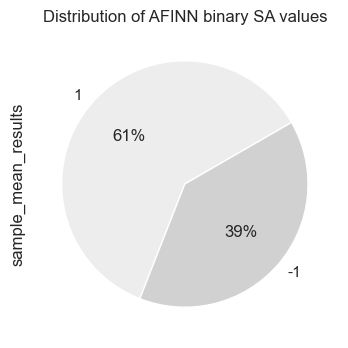

In [31]:
plt.figure(figsize=(4,4))
sns.set(style='white', palette='Greys', font_scale=1.0)

df['sample_mean_results'].value_counts().plot(kind='pie', 
                                          figsize=(4, 4),
                                          autopct='%1.0f%%',
                                          startangle=30, 
                                          title='Distribution of AFINN binary SA values')

In [32]:
# change values to sring
df['correct_mean_results'] = df['correct_mean_results'].astype('int32')

# count values of each label type
df['correct_mean_results'].value_counts()

-1    3948
 1    2681
Name: correct_mean_results, dtype: int64

<AxesSubplot: title={'center': 'Distribution of AFINN binary SA values'}, ylabel='correct_mean_results'>

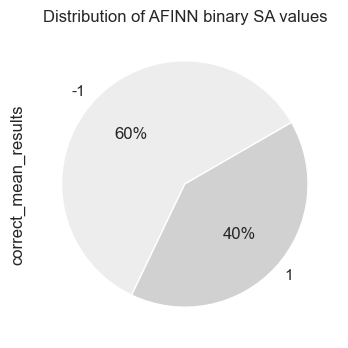

In [33]:
plt.figure(figsize=(4,4))
sns.set(style='white', palette='Greys', font_scale=1.0)

df['correct_mean_results'].value_counts().plot(kind='pie', 
                                          figsize=(4, 4),
                                          autopct='%1.0f%%',
                                          startangle=30, 
                                          title='Distribution of AFINN binary SA values')

# Results analysis for 'raw' samples

In [34]:
df['sentiment'] = df['sentiment'].replace(0, 1)

# create panda dataframe for results
df_results = pd.DataFrame({'sample':df['sample'], 'sentiment':df['sentiment'], 'prediction':df['sample_mean_results']})
df_results

,sample,sentiment,prediction
0,- Ajatus siitä että kaikki henkilön tienaamat...,-1,1
1,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,1
2,--´973´¤-.ttu,-1,1
3,-=>Widdu joo<=-,-1,1
4,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,1
...,...,...,...
6624,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,1,-1
6625,😠👉👩‍💼,-1,1
6626,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,1,1
6627,🤮😡,-1,-1


In [35]:
sentiments = df_results['sentiment'].tolist()
predictions = df_results['prediction'].tolist()

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['negative', 'positive']

print(classification_report(sentiments, predictions, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

    negative       0.91      0.45      0.60      5336
    positive       0.26      0.82      0.40      1293

    accuracy                           0.52      6629
   macro avg       0.59      0.63      0.50      6629
weighted avg       0.79      0.52      0.56      6629



In [37]:
print(confusion_matrix(sentiments, predictions))

[[2375 2961]
 [ 229 1064]]


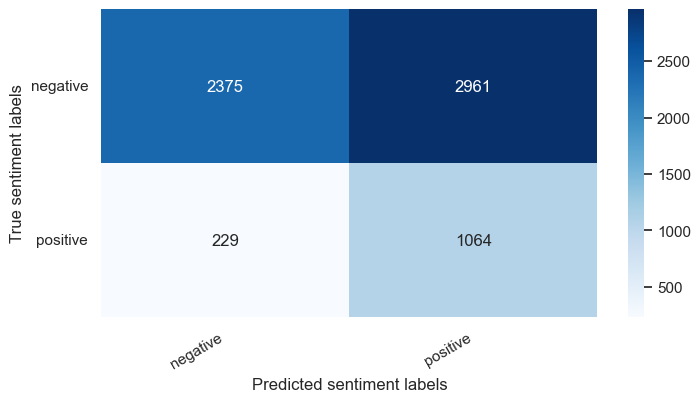

In [38]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment labels')
    plt.xlabel('Predicted sentiment labels');

cm = confusion_matrix(sentiments, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [39]:
# metrics for binary classification
# --------------------------------------------
# The positive value is 1 and the negative value is 0.

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# calculate accuracy
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
total_accuracy = accuracy_score(sentiments, predictions, normalize=True, sample_weight=None)
print('Accuracy  ', total_accuracy)

# calculate f1
# The formula for the F1 score is:    F1 = 2 * (precision * recall) / (precision + recall)
# 'binary': Only report results for the class specified by pos_label. 
# This is applicable only if targets (y_{true,pred}) are binary.
#total_f1 = f1_score(HSbinary, predictions, average='binary', labels=np.unique(predictions), zero_division=0)
total_f1 = f1_score(sentiments, predictions, average='binary', sample_weight=None, zero_division=0)
print('F1  ', total_f1)

# calculate precision
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
total_precision = precision_score(sentiments, predictions, average='binary', sample_weight=None, zero_division=0)
print('Precision  ', total_precision)

# calculate recall
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
# The recall is intuitively the ability of the classifier to find all the positive samples.
#total_recall = recall_score(HSbinary, predictions, average='binary', labels=np.unique(predictions), sample_weight=None, zero_division=0)
total_recall = recall_score(sentiments, predictions, average='binary', sample_weight=None, zero_division=0)
print('Recall  ', total_recall)

Accuracy   0.518781113290089
F1   0.40015043249341853
Precision   0.2643478260869565
Recall   0.822892498066512


In [40]:
#pip install pycm==4.0
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=sentiments, predict_vector=predictions)
cm.print_matrix()

Predict    -1         1          
Actual
-1         2375       2961       

1          229        1064       




In [41]:
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.51878
F1 Macro                                                          0.49919
FPR Macro                                                         0.36601
Kappa                                                             0.14884
NPV Macro                                                         0.5882
Overall ACC                                                       0.51878
PPV Macro                                                         0.5882
SOA1(Landis & Koch)                                               Slight
TPR Macro                                                         0.63399
Zero-one Loss                                                     3190

Class Statistics :

Classes                                                           -1            1             
ACC(Accuracy)                                                     0.51878       0.51878       
AUC(Area under the ROC curve)   

# Results for 'correct' samples

In [42]:
# create panda dataframe for results
df_results = pd.DataFrame({'sample':df['sample'], 'sentiment':df['sentiment'], 'prediction':df['correct_mean_results']})
df_results

,sample,sentiment,prediction
0,- Ajatus siitä että kaikki henkilön tienaamat...,-1,1
1,"- Kaivovertauksessa, viime hallitus on kaivan...",-1,1
2,--´973´¤-.ttu,-1,-1
3,-=>Widdu joo<=-,-1,1
4,"- Ei , mutta olen joutunut elämään katsomalla ...",-1,1
...,...,...,...
6624,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,1,-1
6625,😠👉👩‍💼,-1,1
6626,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,1,1
6627,🤮😡,-1,-1


In [43]:
sentiments = df_results['sentiment'].tolist()
predictions = df_results['prediction'].tolist()

from sklearn.metrics import confusion_matrix, classification_report

class_names = ['positive', 'negative']

print(classification_report(sentiments, predictions, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

    positive       0.93      0.69      0.79      5336
    negative       0.38      0.80      0.52      1293

    accuracy                           0.71      6629
   macro avg       0.66      0.74      0.66      6629
weighted avg       0.83      0.71      0.74      6629



In [44]:
print(confusion_matrix(sentiments, predictions))

[[3687 1649]
 [ 261 1032]]


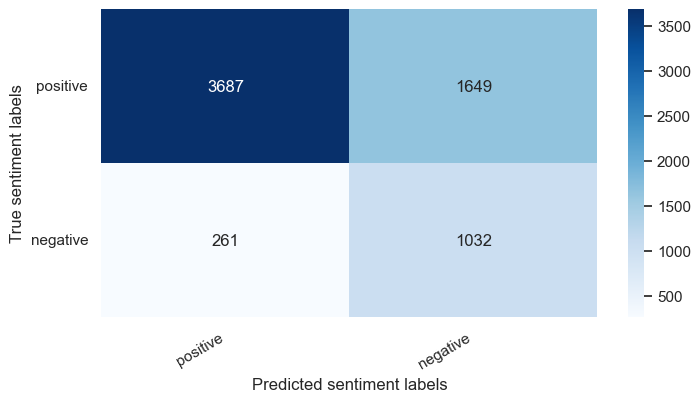

In [45]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment labels')
    plt.xlabel('Predicted sentiment labels');

cm = confusion_matrix(sentiments, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [46]:
# metrics for binary classification
# --------------------------------------------
# The positive value is 1 and the negative value is 0.

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# calculate accuracy
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
total_accuracy = accuracy_score(sentiments, predictions, normalize=True, sample_weight=None)
print('Accuracy  ', total_accuracy)

# calculate f1
# The formula for the F1 score is:    F1 = 2 * (precision * recall) / (precision + recall)
# 'binary': Only report results for the class specified by pos_label. 
# This is applicable only if targets (y_{true,pred}) are binary.
#total_f1 = f1_score(HSbinary, predictions, average='binary', labels=np.unique(predictions), zero_division=0)
total_f1 = f1_score(sentiments, predictions, average='binary', sample_weight=None, zero_division=0)
print('F1  ', total_f1)

# calculate precision
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
total_precision = precision_score(sentiments, predictions, average='binary', sample_weight=None, zero_division=0)
print('Precision  ', total_precision)

# calculate recall
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
# The recall is intuitively the ability of the classifier to find all the positive samples.
#total_recall = recall_score(HSbinary, predictions, average='binary', labels=np.unique(predictions), sample_weight=None, zero_division=0)
total_recall = recall_score(sentiments, predictions, average='binary', sample_weight=None, zero_division=0)
print('Recall  ', total_recall)


Accuracy   0.7118720772363856
F1   0.5193759436336185
Precision   0.3849309958970533
Recall   0.7981438515081206


In [47]:
#pip install pycm==4.0
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=sentiments, predict_vector=predictions)
cm.print_matrix()

Predict    -1         1          
Actual
-1         3687       1649       

1          261        1032       




In [48]:
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.71187
F1 Macro                                                          0.65682
FPR Macro                                                         0.25544
Kappa                                                             0.34771
NPV Macro                                                         0.65941
Overall ACC                                                       0.71187
PPV Macro                                                         0.65941
SOA1(Landis & Koch)                                               Fair
TPR Macro                                                         0.74456
Zero-one Loss                                                     1910

Class Statistics :

Classes                                                           -1            1             
ACC(Accuracy)                                                     0.71187       0.71187       
AUC(Area under the ROC curve)   

# Conclusions

### Accuracy, F1, Precision, and Recall

 - 'raw' text samples

Accuracy   0.50
F1   0.58
Precision   0.77
Recall   0.50

 - 'corrected' text samples

Accuracy   0.71
F1   0.74
Precision   0.80
Recall   0.71

The original 'raw' samples included significant amount of incorrectly written text.

Accuracy value (as value to define how well the set of predicted labels match the corresponding set of true labels) was significantly higher on 'corrected' text samples (accuracy 0.71) than with original 'raw' samples (accuracy 0.50).

F1 value (as value which define how well the predicted positive labels match the corresponding positive true labels) was significantly higher on 'corrected' text samples (accuracy 0.74) than with original 'raw' samples (accuracy 0.58).

Precision (as value to define how well the classifier does not label a negative sample to a positive one) was good for both 'raw' (precision 0.77) and 'corrected' (precision 0.80) sample datasets.

Recall (as value to define how well the classifier does find all the positive samples) was quite low on 'raw' samples (recall 0.50) and significantly better for 'corrected' samples (recall   0.71).

### Confusion matrix

- 'raw' text samples
 - 2685 2224  427
 - 202  247  190
 - 123  135  396


- 'corrected' text samples
 - 4071  832  433
 - 228  203  208
 - 129  113  412

Comparison of confusion matrix results reveals that sentiment lexicon based trinary classification with afinn scoring method produces significantly better results on text data samples that include correctly (or almost correctly) written Finnish.

The amount of correct negative (-1) labeled predictions is significantly higher on 'corrected' samples dataset that it is on oroginal 'raw' samples dataset.

### Conclusion

Lexicon based trinary classification provides fairly good results when data samples is written in incorrect Finnish, or text samples include words, emoticons or emojis that are included in sentiment lexicons.

The method has significant challenges on neutral (0) labeled text samples. The method gives better results for negative (-1) or positive (1) labeled text samples.
